#  MS Upregulated Biomarker Test Cohort

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 03NOV2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Notes**: 
1. 

<a id="0"></a>

## Notebook Content

1.  [Statistical Significance Tests](#1)
2.  [RCC Classification: Model Cohort + Hyperparameter Tuning](#2)
3.  [RCC Classification: Test Cohort](#3)

In [1]:
import dill
filepath = 'MS_Upregulated_Biomarker_Test_Cohort.pkl'
dill.load_session('workspace/MS_Upregulated_Biomarker_Test_Cohort.pkl') # Load the session

In [2]:
# Global seed
import random  
random.seed(42)

#import os
#os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
import numpy as np
np.random.seed(42)
from matplotlib import pyplot as plt
from matplotlib import style

#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

In [3]:
import scipy
import statsmodels as sms
from statsmodels.stats import multitest
# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn import decomposition

from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from statistics import mean

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

T-test function

In [4]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

_Machine Learning Model Function_

In [5]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [6]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)

## 3. RCC Classification: Test Cohort
<a id="3"></a>

In [7]:
final_features = {1481, 2102, 5698, 6578, 6594}
final_features_ID = {'2-mercaptobenzothiazole','Lys-Ile', 
                     'Dibutylamine','N-Acetyl-D-Glucosamine',
                     'm/z 630.19'}

In [8]:
testcohort = pd.read_excel('data/testcohort.xlsx', index_col=0)

testcohort.rename(columns={6578:'2-mercaptobenzothiazole', 1481:'Lys-Ile',
                          2102:'Dibutylamine', 6594:'N-Acetyl-D-Glucosamine',
                         5698:'m/z 630.19'}, 
                 inplace=True)

# MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]

MLfeatures2 = testcohort[final_features_ID] 

MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 5)

In [9]:
# define features and label.
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 5)
(194,)


Model is already loaded in workspace. 

##### Random Forest
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=150, min_samples_split=2, 
                          min_samples_leaf=1, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


###### Linear-SVM
linsvm = svm.SVC(C = 10, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


###### SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 10, gamma = 0.3, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

###### KNN
knn = KNeighborsClassifier(n_neighbors=11, p=2)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

In [10]:
print(RF)
print(linsvm)
print(clf)
print(knn)

RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)
SVC(C=10, kernel='linear', probability=True, random_state=42)
SVC(C=10, gamma=0.3, probability=True, random_state=42)
KNeighborsClassifier(n_neighbors=11)


**AUC**

In [11]:
sns.set_context('talk', font_scale=0.8)

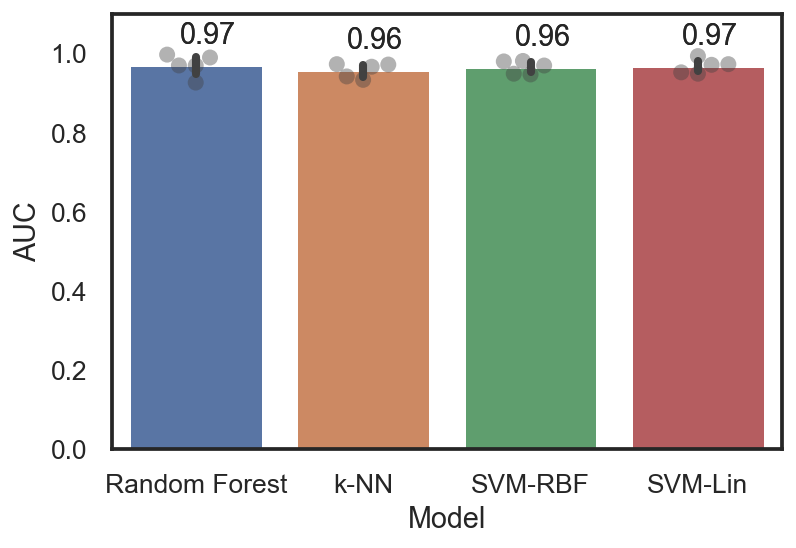

In [12]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

In [13]:
# A function to print out all numeric (and summary of) results
def summary(name, result):
    print ('All Test result for', name, result)
    print ('Summary metric for', name, round(mean(result),2),'+/-', round(np.std(result),2))

In [14]:
summary('Random Forest', RF_AUC)
summary('k-NN', KNN_AUC)
summary('RBF SVM', clf_AUC)
summary('Linear SVM', linsvm_AUC)

All Test result for Random Forest [0.9691558441558442, 0.9689655172413792, 0.996551724137931, 0.9258620689655173, 0.9892857142857143]
Summary metric for Random Forest 0.97 +/- 0.02
All Test result for k-NN [0.9659090909090908, 0.9413793103448276, 0.9724137931034483, 0.9327586206896551, 0.9714285714285713]
Summary metric for k-NN 0.96 +/- 0.02
All Test result for RBF SVM [0.9805194805194806, 0.9689655172413794, 0.9793103448275862, 0.9482758620689655, 0.9464285714285714]
Summary metric for RBF SVM 0.96 +/- 0.01
All Test result for Linear SVM [0.9707792207792207, 0.9482758620689655, 0.9517241379310346, 0.9724137931034483, 0.9928571428571429]
Summary metric for Linear SVM 0.97 +/- 0.02


**Accuracy**

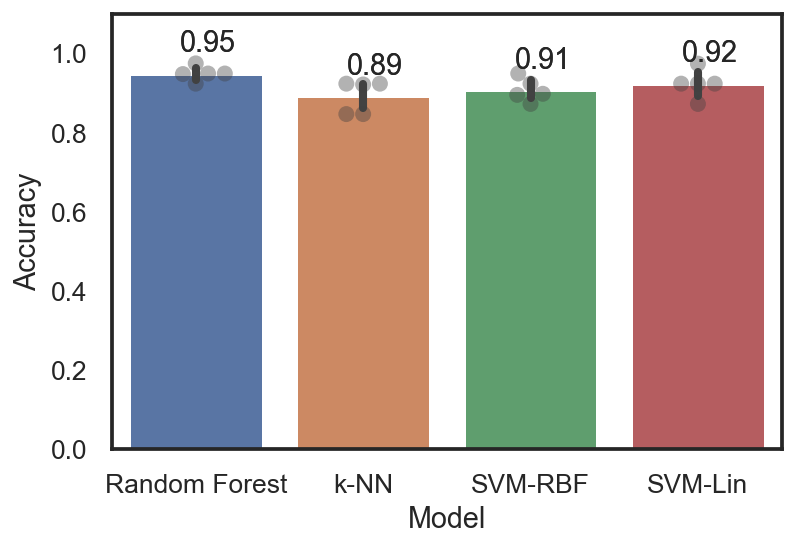

In [15]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

In [16]:
summary('Random Forest', RF_ACC)
summary('k-NN', KNN_ACC)
summary('RBF SVM', clf_ACC)
summary('Linear SVM', linsvm_ACC)

All Test result for Random Forest [0.9230769230769231, 0.9487179487179487, 0.9487179487179487, 0.9743589743589743, 0.9473684210526315]
Summary metric for Random Forest 0.95 +/- 0.02
All Test result for k-NN [0.9230769230769231, 0.8461538461538461, 0.8461538461538461, 0.9230769230769231, 0.9210526315789473]
Summary metric for k-NN 0.89 +/- 0.04
All Test result for RBF SVM [0.9487179487179487, 0.9230769230769231, 0.8717948717948718, 0.8974358974358975, 0.8947368421052632]
Summary metric for RBF SVM 0.91 +/- 0.03
All Test result for Linear SVM [0.9230769230769231, 0.9230769230769231, 0.8717948717948718, 0.9230769230769231, 0.9736842105263158]
Summary metric for Linear SVM 0.92 +/- 0.03


**Precision**

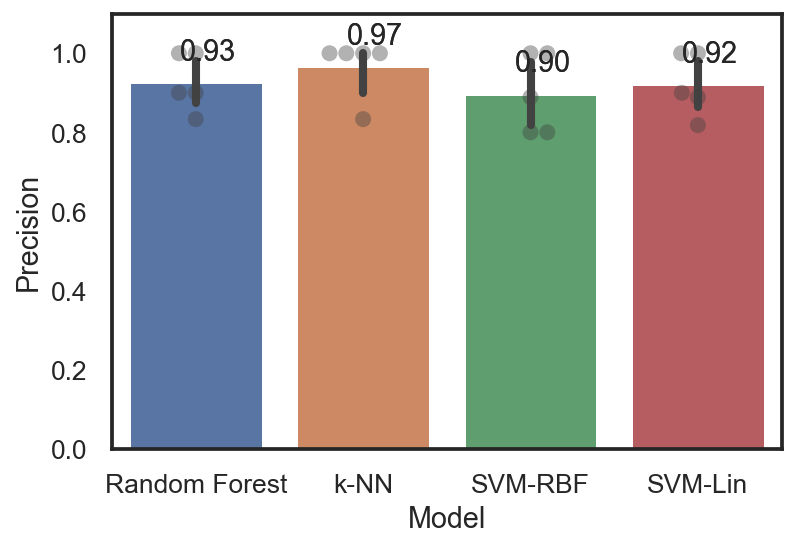

In [17]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

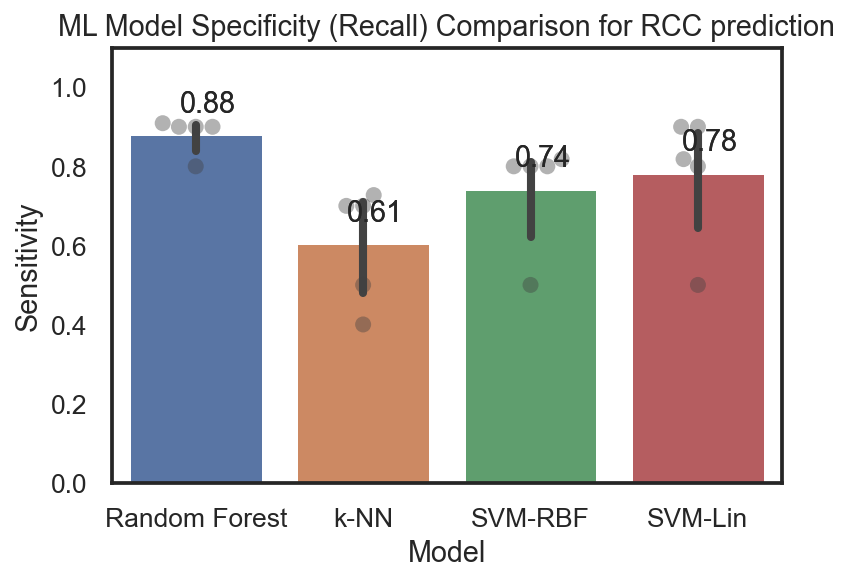

In [18]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

In [19]:
summary('Random Forest', RF_REC)
summary('k-NN', KNN_REC)
summary('RBF SVM', clf_REC)
summary('Linear SVM', linsvm_REC)

All Test result for Random Forest [0.9090909090909091, 0.9, 0.8, 0.9, 0.9]
Summary metric for Random Forest 0.88 +/- 0.04
All Test result for k-NN [0.7272727272727273, 0.5, 0.4, 0.7, 0.7]
Summary metric for k-NN 0.61 +/- 0.13
All Test result for RBF SVM [0.8181818181818182, 0.8, 0.5, 0.8, 0.8]
Summary metric for RBF SVM 0.74 +/- 0.12
All Test result for Linear SVM [0.8181818181818182, 0.8, 0.5, 0.9, 0.9]
Summary metric for Linear SVM 0.78 +/- 0.15


**F1 Score**

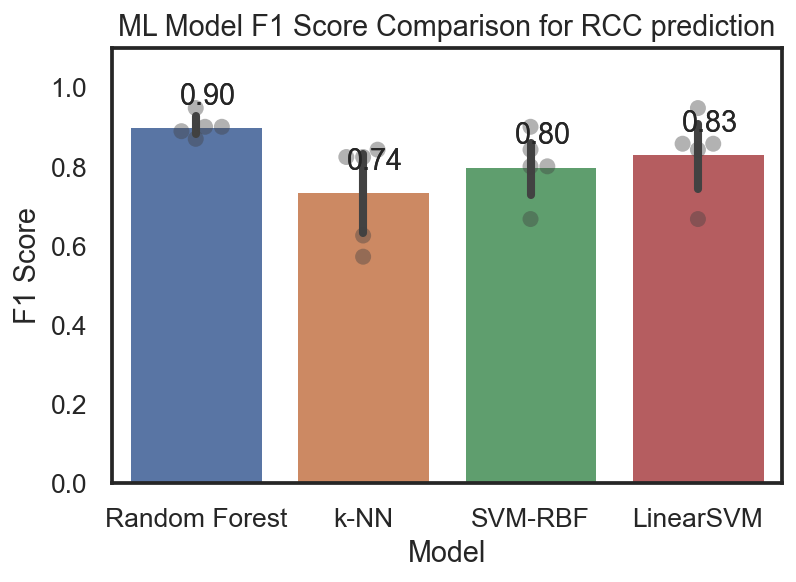

In [20]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

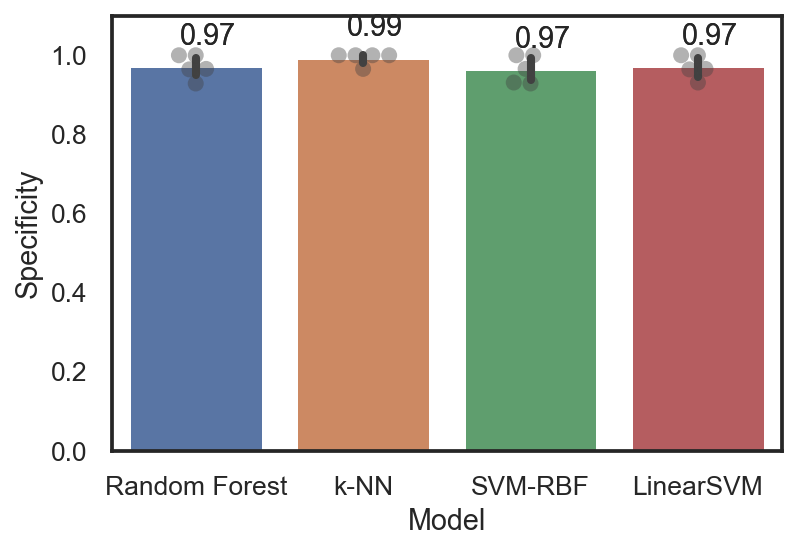

In [21]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

In [22]:
summary('Random Forest', RF_SPE)
summary('k-NN', KNN_SPE)
summary('RBF SVM', clf_SPE)
summary('Linear SVM', linsvm_SPE)

All Test result for Random Forest [0.9285714285714286, 0.9655172413793104, 1.0, 1.0, 0.9642857142857143]
Summary metric for Random Forest 0.97 +/- 0.03
All Test result for k-NN [1.0, 0.9655172413793104, 1.0, 1.0, 1.0]
Summary metric for k-NN 0.99 +/- 0.01
All Test result for RBF SVM [1.0, 0.9655172413793104, 1.0, 0.9310344827586207, 0.9285714285714286]
Summary metric for RBF SVM 0.97 +/- 0.03
All Test result for Linear SVM [0.9642857142857143, 0.9655172413793104, 1.0, 0.9310344827586207, 1.0]
Summary metric for Linear SVM 0.97 +/- 0.03


One of the best classifier is RF, and here are the feature importance from random forest:

### Feature Importance Score

No handles with labels found to put in legend.


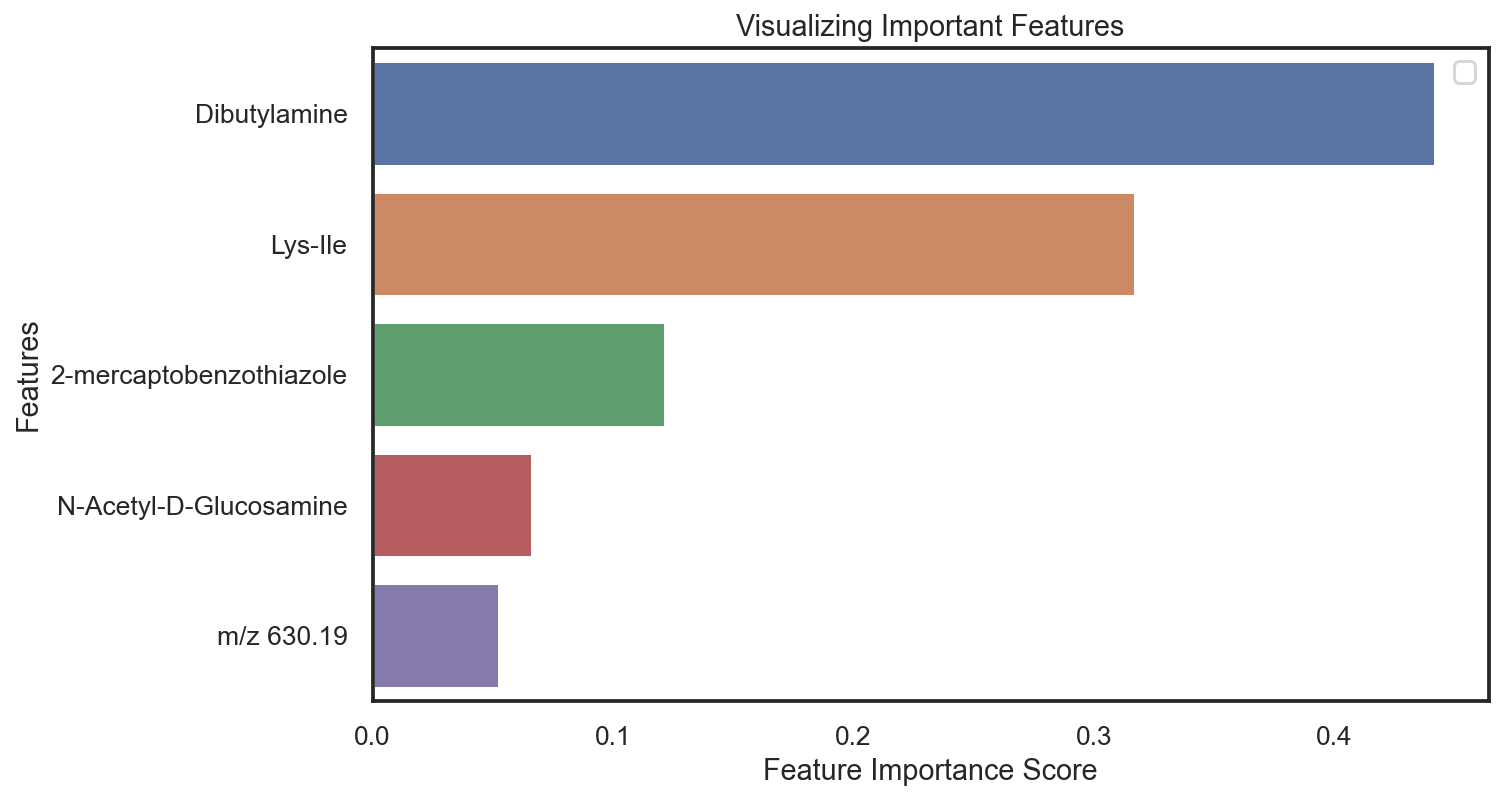

In [23]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures2.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [24]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 5)


In [25]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 6)

**_T_-test for metabolic features in the test cohort**

In [26]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[final_features_ID]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [27]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

,Metabolite,T-test p-value,FDR p-value,Reject H0
1,Dibutylamine,6.805514e-11,3.402757e-10,True
3,Lys-Ile,3.639234e-07,9.098084e-07,True
4,N-Acetyl-D-Glucosamine,3.604872e-04,6.008120e-04,True
0,2-mercaptobenzothiazole,1.035021e-03,1.293776e-03,True
2,m/z 630.19,6.134801e-03,6.134801e-03,True


Boxplot

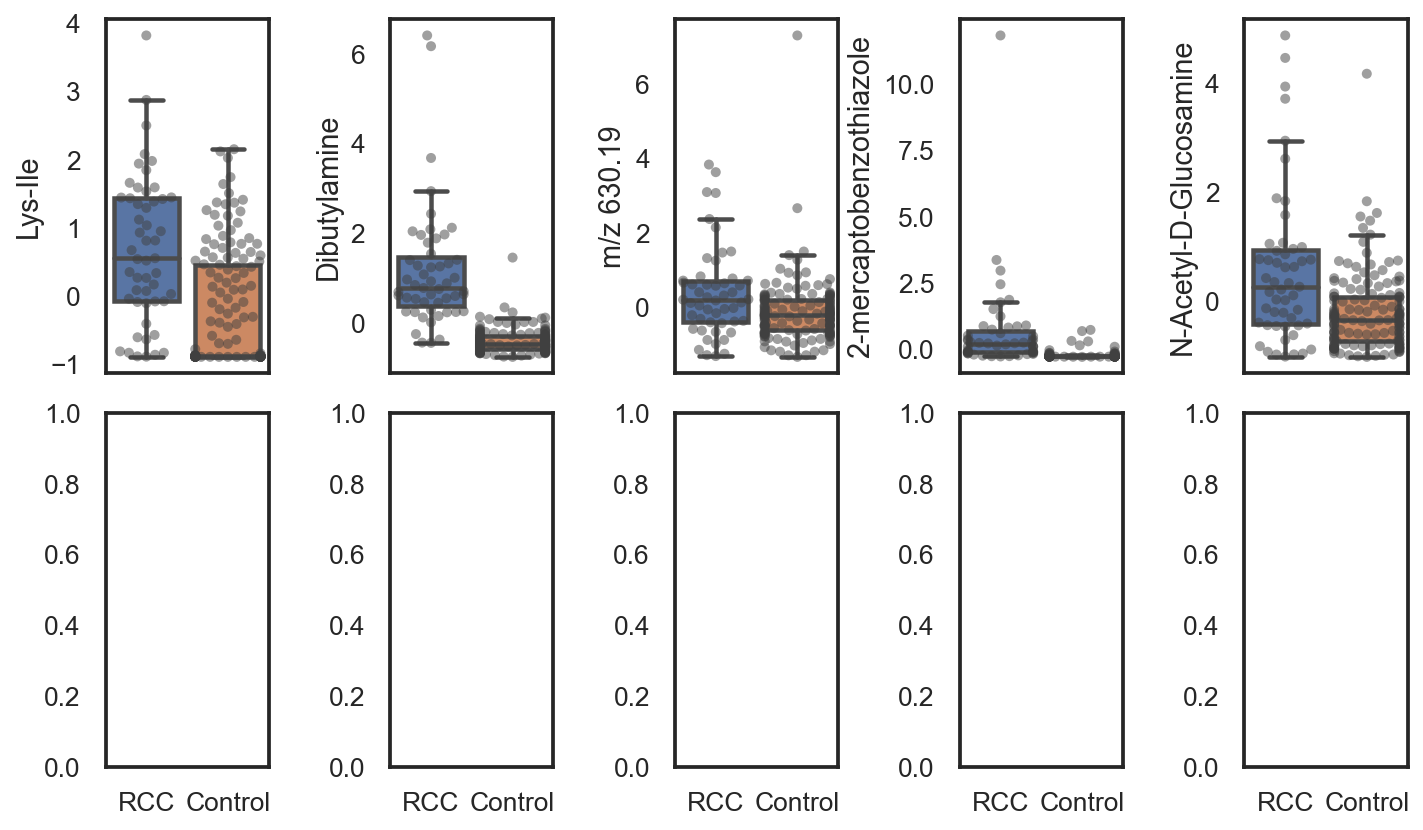

In [4]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(10, 6))
for idx, feat in enumerate(biomarker2.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker2, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=5, alpha=0.5, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('MSupregulated_biomarker_test.svg', dpi=300)

**PCA**

In [29]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

**PCA score plots using all ML features**

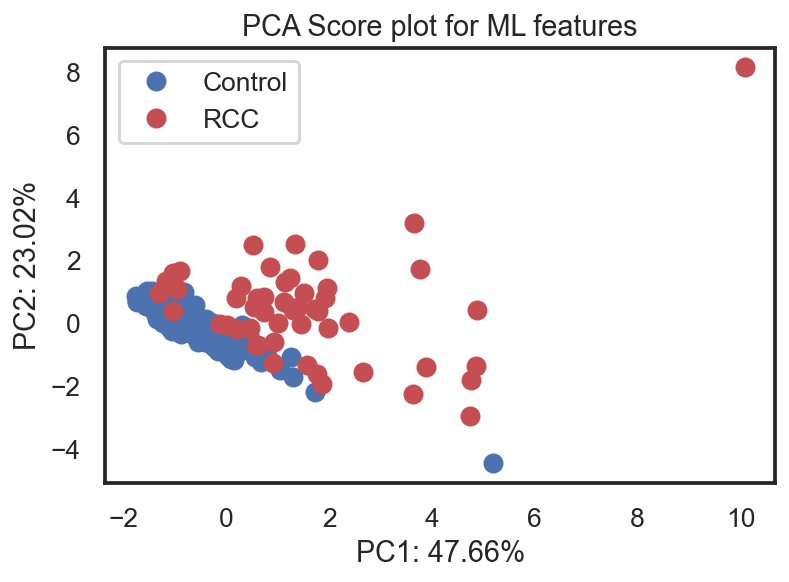

In [30]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
PCA_Python(MLfeatures2, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [31]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 6)

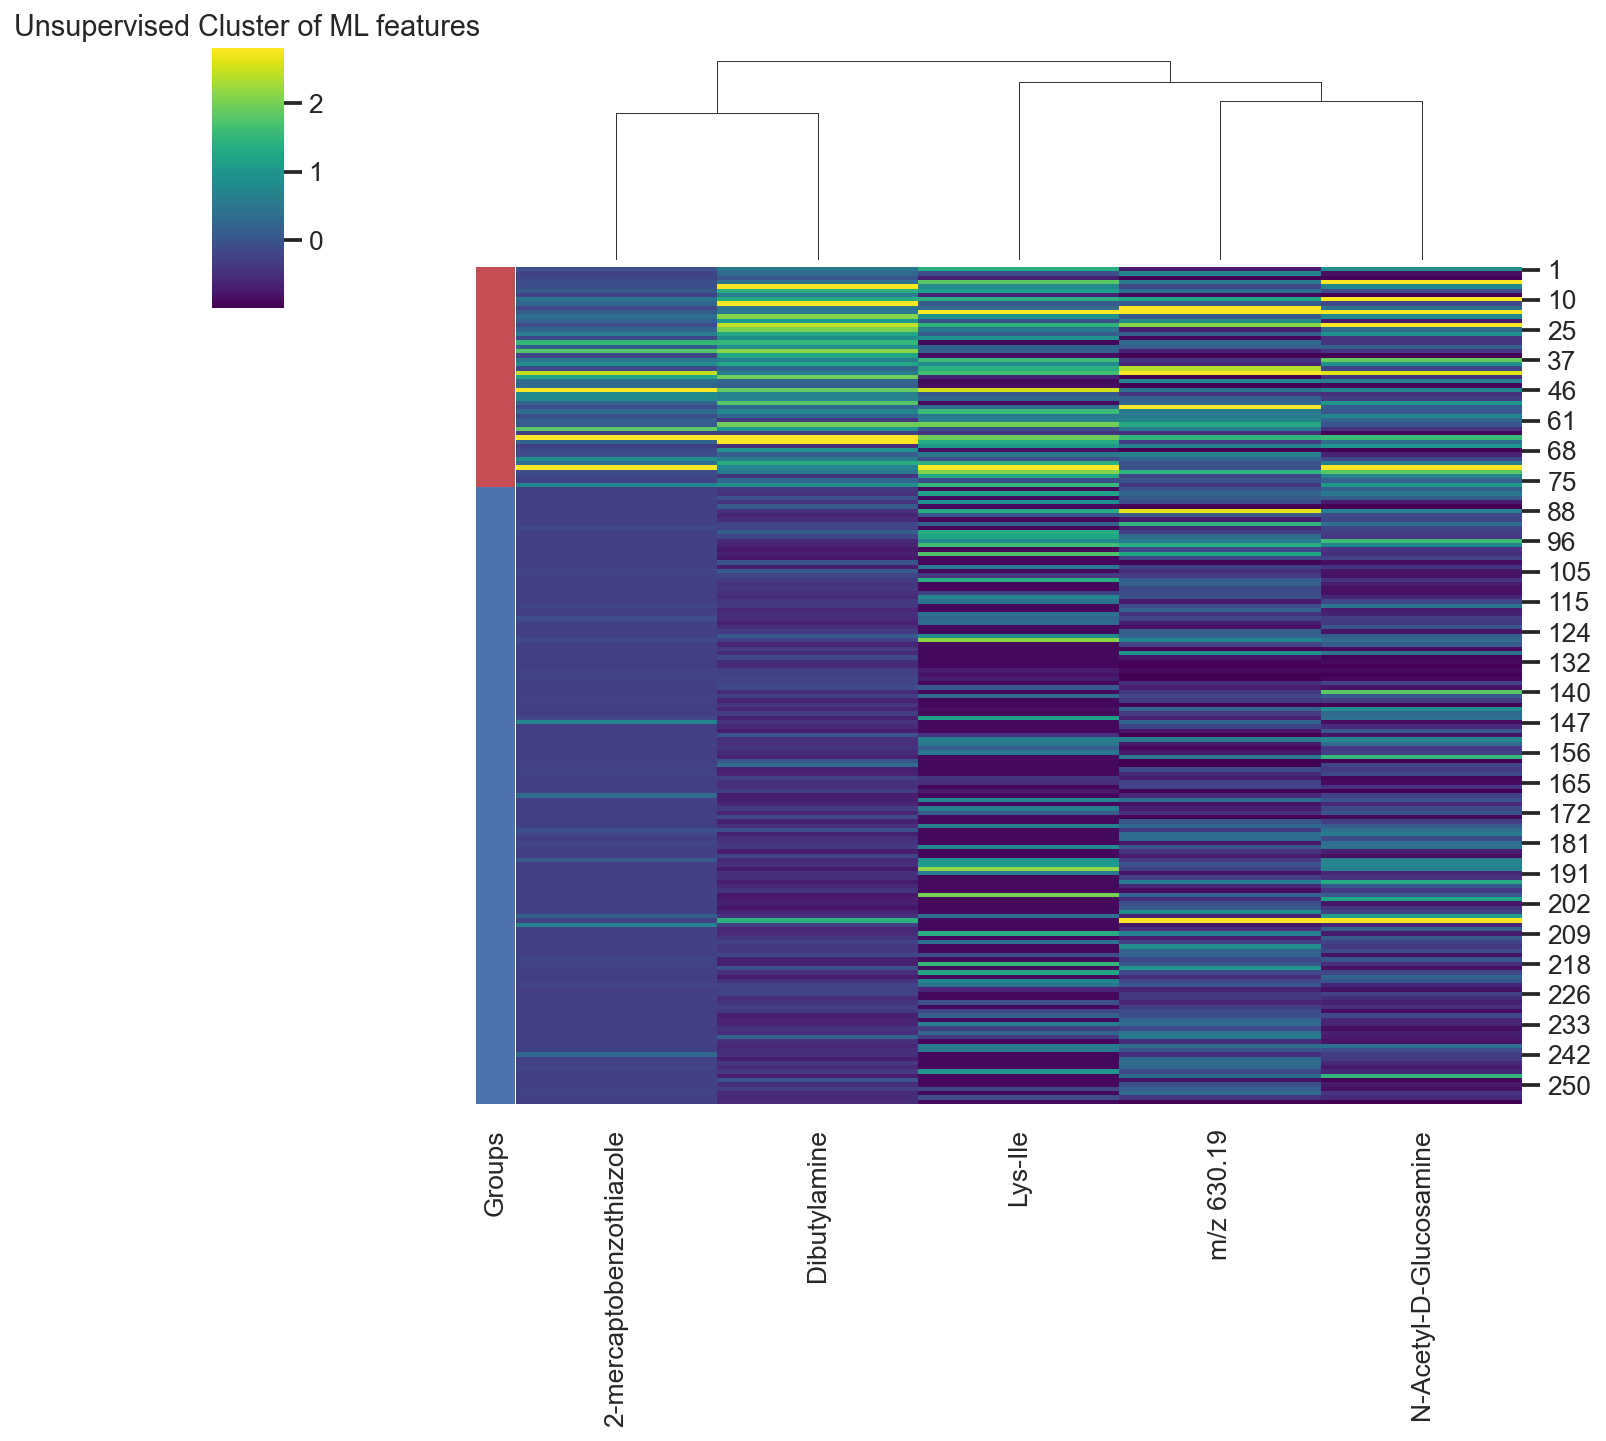

In [32]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)

In [33]:
#import dill                            
#filepath = 'MS_Upregulated_Biomarker_Test_Cohort.pkl'
#dill.dump_session(filepath) # Save the session